In [ ]:
import glob
import json
import math
import os
import random
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

output_dir = "./output"
os.makedirs(output_dir, exist_ok=True)

### 1. Data preprocessing
+ 1.1 observation and cleaning
+ 1.2 splitting
+ 1.3 numpy or dataloader

### Data observation and cleaning

In [3]:
df = pd.read_excel(glob.glob("/app/dataset/raw/20250921_历史数据+每周排名/binance_history_data/*.xlsx")[0])
print(df.shape)
df.head()

(1594, 6)


,open,high,low,close,volume,date
0,0.027258,0.039960,0.024929,0.034839,11148362801,2021-05-10
1,0.034835,0.037709,0.027675,0.030494,39894056282,2021-05-11
2,0.030487,0.031556,0.015000,0.018181,111299141702,2021-05-12
3,0.018173,0.022807,0.014450,0.020690,112036196185,2021-05-13
4,0.020672,0.021553,0.018173,0.018415,39444778187,2021-05-14


In [4]:
df['date'][0], df['date'][len(df) - 1]

(Timestamp('2021-05-10 00:00:00'), Timestamp('2025-09-19 00:00:00'))

In [5]:
for xlsx_path in glob.glob("/app/dataset/raw/20250921_历史数据+每周排名/binance_history_data/*.xlsx"):
    df = pd.read_excel(xlsx_path)

    # check missing
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            print(f"{xlsx_path}: Column '{col}' has {missing_count} missing values.")

    # check_date_interval
    diff_series = pd.to_datetime(df['date']).diff()
    if list(diff_series.value_counts().to_dict().keys()) != [pd.Timedelta('1 days')]:
        print(f"{xlsx_path}: Date intervals in 'date' are inconsistent.")

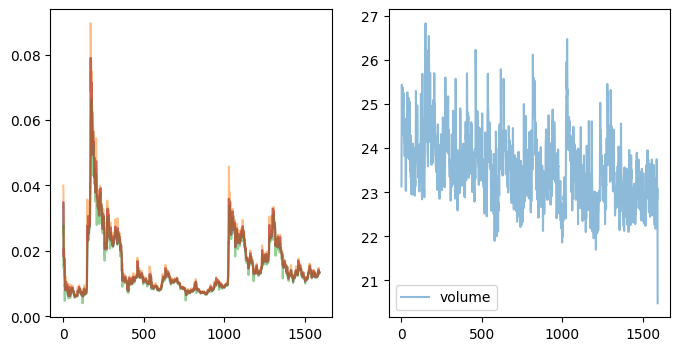

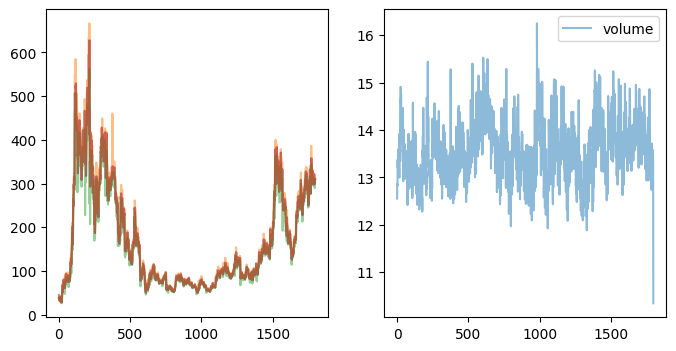

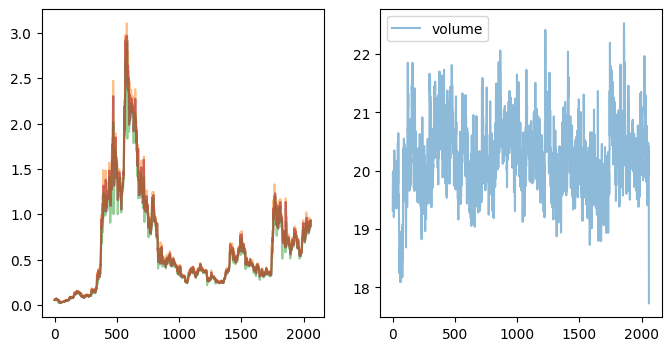

In [6]:
for i, xlsx_path in enumerate(glob.glob("/app/dataset/raw/20250921_历史数据+每周排名/binance_history_data/*.xlsx")):
    if i >= 3:
        break
    df = pd.read_excel(xlsx_path)
    plt.figure(figsize=(8, 4))
    #
    plt.subplot(1, 2, 1)
    for col in df.columns:
        if col not in ("date", "volume"):
            plt.plot(df[col], label=col, alpha=0.5)
    #
    plt.subplot(1, 2, 2)
    plt.plot(np.log(df["volume"]), label="volume", alpha=0.5)
    plt.legend()
    plt.show()

In [7]:
# Describe
df = pd.read_excel(glob.glob("/app/dataset/raw/20250921_历史数据+每周排名/binance_history_data/*.xlsx")[0])
dataset_describe = df.describe()
dataset_describe.loc["log_min"] = dataset_describe.loc["min"].apply(lambda x: np.log(x) if isinstance(x, np.float64) else None)
dataset_describe.loc["log_max"] = dataset_describe.loc["max"].apply(lambda x: np.log(x) if isinstance(x, np.float64) else None)
dataset_describe.to_csv(f"{output_dir}/dataset_describe.csv")
dataset_describe

,open,high,low,close,volume,date
count,1594.000000,1594.000000,1594.000000,1594.000000,1.594000e+03,1594
mean,0.015586,0.016340,0.014813,0.015577,2.439537e+10,2023-07-15 12:00:00
min,0.005882,0.006233,0.004000,0.005882,7.857922e+08,2021-05-10 00:00:00
25%,0.009132,0.009471,0.008824,0.009132,9.773770e+09,2022-06-12 06:00:00
50%,0.012308,0.012723,0.011911,0.012308,1.518956e+10,2023-07-15 12:00:00
75%,0.020146,0.020997,0.018558,0.020110,2.526384e+10,2024-08-16 18:00:00
max,0.078997,0.089575,0.066500,0.079004,4.509923e+11,2025-09-19 00:00:00
std,0.009397,0.010210,0.008596,0.009393,3.365644e+10,NaN
log_min,-5.135858,-5.077898,-5.521461,-5.135858,2.048220e+01,NaN
log_max,-2.538345,-2.412679,-2.710553,-2.538257,2.683472e+01,NaN


In [8]:
# normalizer
class Normalizer:
    def __init__(self, describe: pd.DataFrame = None):
        self.des = describe

    def _norm(self, col: str, ser: pd.Series) -> pd.Series:
        return (ser - self.des[col]["min"]) / (self.des[col]["max"] - self.des[col]["min"])

    def _denorm(self, col: str, ser: pd.Series) -> pd.Series:
        return ser * (self.des[col]["max"] - self.des[col]["min"]) + self.des[col]["min"]

    def _log_norm(self, col: str, ser: pd.Series) -> pd.Series:
        log_ser = np.log(ser)
        return (log_ser - self.des[col]["log_min"]) / (self.des[col]["log_max"] - self.des[col]["log_min"])

    def _log_denorm(self, col: str, ser: pd.Series) -> pd.Series:
        return np.exp(ser * (self.des[col]["log_max"] - self.des[col]["log_min"]) + self.des[col]["log_min"])

    def run(self, df: pd.DataFrame, map_dict: dict) -> pd.DataFrame:
        new_df = df.copy()
        for col, method in map_dict.items():
            new_df[col] = getattr(self, f"_{method}")(col, new_df[col])
        return new_df

norm_map_dict = {k: "norm" for k in df.columns if k not in ("date", "volume")} | {"volume": "log_norm"}
denorm_map_dict = {k: "denorm" for k in df.columns if k not in ("date", "volume")} | {"volume": "log_denorm"}

In [9]:
normalizer = Normalizer(dataset_describe)
df_norm = normalizer.run(df, norm_map_dict)
df_norm

,open,high,low,close,volume,date
0,0.292361,0.404682,0.334864,0.396009,0.417529,2021-05-10
1,0.395993,0.377673,0.378800,0.336588,0.618226,2021-05-11
2,0.336525,0.303844,0.176000,0.168198,0.779736,2021-05-12
3,0.168105,0.198867,0.167200,0.202511,0.780775,2021-05-13
4,0.202284,0.183821,0.226768,0.171398,0.616443,2021-05-14
...,...,...,...,...,...,...
1589,0.106654,0.090867,0.142576,0.098151,0.445824,2025-09-15
1590,0.098147,0.084183,0.141696,0.099437,0.371598,2025-09-16
1591,0.099460,0.088419,0.141104,0.104086,0.410920,2025-09-17
1592,0.104110,0.088467,0.148304,0.102773,0.355070,2025-09-18


In [10]:
normalizer.run(df_norm, denorm_map_dict)

,open,high,low,close,volume,date
0,0.027258,0.039960,0.024929,0.034839,1.114836e+10,2021-05-10
1,0.034835,0.037709,0.027675,0.030494,3.989406e+10,2021-05-11
2,0.030487,0.031556,0.015000,0.018181,1.112991e+11,2021-05-12
3,0.018173,0.022807,0.014450,0.020690,1.120362e+11,2021-05-13
4,0.020672,0.021553,0.018173,0.018415,3.944478e+10,2021-05-14
...,...,...,...,...,...,...
1589,0.013680,0.013806,0.012911,0.013059,1.334360e+10,2025-09-15
1590,0.013058,0.013249,0.012856,0.013153,8.327111e+09,2025-09-16
1591,0.013154,0.013602,0.012819,0.013493,1.069006e+10,2025-09-17
1592,0.013494,0.013606,0.013269,0.013397,7.497180e+09,2025-09-18


In [11]:
# sliding window
df_norm = df_norm.set_index("date")

window_size = 64
dataset = []
for i in range(len(df_norm) - window_size):
    one_data = df_norm.iloc[i: i + window_size].copy()
    # shape = (window_size, num_features) = (64, 4)

    for col in df_norm.columns:
        one_data[f"y_{col}"] = df_norm.iloc[i + window_size][col]
    one_data["series_id"] = i
    # shape = (window_size, num_features * 2 + 1) = (64, 9)

    dataset.append(one_data)
    
dataset = pd.concat(dataset, axis=0)
dataset

,open,high,low,close,volume,y_open,y_high,y_low,y_close,y_volume,series_id
date,,,,,,,,,,,
2021-05-10,0.292361,0.404682,0.334864,0.396009,0.417529,0.022868,0.016366,0.048592,0.016835,0.422958,0
2021-05-11,0.395993,0.377673,0.378800,0.336588,0.618226,0.022868,0.016366,0.048592,0.016835,0.422958,0
2021-05-12,0.336525,0.303844,0.176000,0.168198,0.779736,0.022868,0.016366,0.048592,0.016835,0.422958,0
2021-05-13,0.168105,0.198867,0.167200,0.202511,0.780775,0.022868,0.016366,0.048592,0.016835,0.422958,0
2021-05-14,0.202284,0.183821,0.226768,0.171398,0.616443,0.022868,0.016366,0.048592,0.016835,0.422958,0
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-14,0.114888,0.096818,0.152608,0.106644,0.412322,0.102783,0.087879,0.150288,0.103813,0.000000,1529
2025-09-15,0.106654,0.090867,0.142576,0.098151,0.445824,0.102783,0.087879,0.150288,0.103813,0.000000,1529
2025-09-16,0.098147,0.084183,0.141696,0.099437,0.371598,0.102783,0.087879,0.150288,0.103813,0.000000,1529


In [18]:
# splitting
seed = 7
random.seed(seed)

n_all = len(dataset) // window_size
n_train = int(n_all * 0.8)
train_indices = list(range(n_all))[:n_train]
valid_indices = list(range(n_all))[n_train:]
random.shuffle(train_indices)
train_indices_df = pd.DataFrame({"series_id": train_indices})
valid_indices_df = pd.DataFrame({"series_id": valid_indices})

train_dataset = train_indices_df.merge(dataset, on="series_id")
valid_dataset = valid_indices_df.merge(dataset, on="series_id")

train_dataset.shape, valid_dataset.shape
print(train_dataset)
valid_dataset

       series_id      open      high       low     close    volume    y_open  \
0            353  0.239773  0.207326  0.298400  0.233076  0.396764  0.061055   
1            353  0.233099  0.202431  0.281200  0.223066  0.433987  0.061055   
2            353  0.223073  0.194944  0.228944  0.195085  0.481120  0.061055   
3            353  0.195104  0.190924  0.251504  0.213999  0.494951  0.061055   
4            353  0.213978  0.186089  0.258224  0.202224  0.426791  0.061055   
...          ...       ...       ...       ...       ...       ...       ...   
78331        663  0.055761  0.046615  0.093552  0.056454  0.345404  0.048772   
78332        663  0.056459  0.047611  0.092816  0.057931  0.396693  0.048772   
78333        663  0.057922  0.046699  0.093776  0.054758  0.339655  0.048772   
78334        663  0.054763  0.045643  0.090880  0.056221  0.410420  0.048772   
78335        663  0.056213  0.045859  0.082032  0.048768  0.478162  0.048772   

         y_high     y_low   y_close  y_

,series_id,open,high,low,close,volume,y_open,y_high,y_low,y_close,y_volume
0,1224,0.107310,0.091526,0.148240,0.102500,0.271009,0.258811,0.235560,0.320480,0.259730,0.539518
1,1224,0.102523,0.086751,0.143920,0.099710,0.321679,0.258811,0.235560,0.320480,0.259730,0.539518
2,1224,0.099720,0.087987,0.144416,0.101543,0.327489,0.258811,0.235560,0.320480,0.259730,0.539518
3,1224,0.101552,0.089595,0.143152,0.106821,0.362982,0.258811,0.235560,0.320480,0.259730,0.539518
4,1224,0.106832,0.100250,0.155088,0.112278,0.401321,0.258811,0.235560,0.320480,0.259730,0.539518
...,...,...,...,...,...,...,...,...,...,...,...
19579,1529,0.114888,0.096818,0.152608,0.106644,0.412322,0.102783,0.087879,0.150288,0.103813,0.000000
19580,1529,0.106654,0.090867,0.142576,0.098151,0.445824,0.102783,0.087879,0.150288,0.103813,0.000000
19581,1529,0.098147,0.084183,0.141696,0.099437,0.371598,0.102783,0.087879,0.150288,0.103813,0.000000
19582,1529,0.099460,0.088419,0.141104,0.104086,0.410920,0.102783,0.087879,0.150288,0.103813,0.000000


In [19]:
num_input_features = 5  # remember to change if num_features change

train_x = train_dataset.iloc[:, 1: 1 + num_input_features].to_numpy()
valid_x = valid_dataset.iloc[:, 1: 1 + num_input_features].to_numpy()
train_x = train_x.reshape(-1, window_size, num_input_features)
valid_x = valid_x.reshape(-1, window_size, num_input_features)

train_y = train_dataset.iloc[:, 1 + num_input_features: 1 + num_input_features * 2].to_numpy()
valid_y = valid_dataset.iloc[:, 1 + num_input_features: 1 + num_input_features * 2].to_numpy()
train_y = train_y[::window_size, :]
valid_y = valid_y[::window_size, :]

train_x.shape, train_y.shape, valid_x.shape, valid_y.shape

((1224, 64, 5), (1224, 5), (306, 64, 5), (306, 5))

In [20]:
class ToyTimeSeriesRegressionDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray):
        """
        Args:
            x (np.ndarray): shape = (num_data, window_size, num_input_features)
            y (torch.Tensor): shape = (num_data, window_size, num_output_features)
        """
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self) -> int:
        return len(self.x)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
            x (torch.Tensor): shape = (window_size, num_input_features)
            y (torch.Tensor): shape = (num_output_features,)
        """
        return self.x[index], self.y[index]


trainset = ToyTimeSeriesRegressionDataset(train_x, train_y)
validset = ToyTimeSeriesRegressionDataset(valid_x, valid_y)
trainset[0]

(tensor([[0.2398, 0.2073, 0.2984, 0.2331, 0.3968],
         [0.2331, 0.2024, 0.2812, 0.2231, 0.4340],
         [0.2231, 0.1949, 0.2289, 0.1951, 0.4811],
         [0.1951, 0.1909, 0.2515, 0.2140, 0.4950],
         [0.2140, 0.1861, 0.2582, 0.2022, 0.4268],
         [0.2022, 0.1776, 0.2548, 0.1972, 0.3921],
         [0.1972, 0.1878, 0.2600, 0.2174, 0.4656],
         [0.2174, 0.1890, 0.2450, 0.1966, 0.4943],
         [0.1966, 0.1697, 0.2478, 0.1932, 0.4527],
         [0.1932, 0.1659, 0.2341, 0.1830, 0.3947],
         [0.1830, 0.1572, 0.2272, 0.1715, 0.4293],
         [0.1715, 0.1496, 0.1543, 0.1105, 0.6350],
         [0.1105, 0.1405, 0.1520, 0.1405, 0.6960],
         [0.1405, 0.1264, 0.1122, 0.0843, 0.6929],
         [0.0843, 0.0807, 0.0806, 0.0678, 0.6849],
         [0.0678, 0.0976, 0.1034, 0.0947, 0.6508],
         [0.0947, 0.0897, 0.1179, 0.0910, 0.5794],
         [0.0910, 0.0819, 0.1265, 0.0980, 0.5012],
         [0.0980, 0.0818, 0.1237, 0.0834, 0.5234],
         [0.0835, 0.0785, 0.127

In [21]:
batch_size = 16

trainloader = DataLoader(trainset, batch_size=batch_size, pin_memory=False, shuffle=False)
validloader = DataLoader(validset, batch_size=batch_size, pin_memory=False, shuffle=False)

### 2. Model prepatation
+ 2.1 model
+ 2.2 loss
+ 2.3 more hyperparameters

In [22]:
# model

model_name = "LSTM"
#model_name = "Transformer"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [23]:
class ToyTimeSeriesRegressionLSTM(torch.nn.Module):
    def __init__(
            self,
            window_size: int,
            num_input_features: int,
            num_output_features: int,
            hidden_size: int = 64
        ):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_size = num_input_features,
            hidden_size = hidden_size,
            num_layers = 3,
            batch_first = True,
        )
        self.flatten = torch.nn.Flatten(start_dim = 1)
        self.dense = torch.nn.Linear(hidden_size * window_size, num_output_features)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape=(batch_size, window_size, num_input_features)
        Returns:
            x (torch.Tensor): shape=(batch_size, num_output_features)
        """
        x, (_, _) = self.lstm(x)  # shape = (batch_size, window_size, hidden_size)
        x = self.flatten(x)  # shaoe = (batch_size, window_size * hidden_size)
        x = self.dense(x)
        return x
    

if model_name == "LSTM":
    example_x, example_y = next(iter(trainset))
    window_size, num_input_features = example_x.shape 
    num_output_features = example_y.numel()
    model = ToyTimeSeriesRegressionLSTM(
            window_size,
            num_input_features,
            num_output_features,
            hidden_size = 32
        ).to(device)
    print(model)
    print("num_parameters:", sum(p.numel() for p in model.parameters()))
    print(model(example_x.reshape(-1, window_size, num_input_features)).shape)

ToyTimeSeriesRegressionLSTM(
  (lstm): LSTM(5, 32, num_layers=3, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Linear(in_features=2048, out_features=5, bias=True)
)
num_parameters: 32133
torch.Size([1, 5])


In [24]:
class PositionalEncoding(torch.nn.Module):
    """
    PE(pos, i)
        where pos = 0, 1, 2, ..., window_size - 1
        and i = 0, 1, 2, ..., num_input_features - 1
    
    for i = even -> sin(pos / 10000 ** (2 * i / num_input_features))
    for i = odd  -> cos(pos / 10000 ** (2 * i / num_input_features))

    Notes:
        + window_size = content length = sequence length
        + num_input_features = d_model = encoding size = embedding size
    """
    def __init__(self, num_input_features: int, max_len: int = 5000):
        """
        max_len has same axis as window_size. that means it supports all window_size within 1~5000.
        """
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)   # shape = (max_len, 1). i.e. [[0],[1],[2],...,[5000]]
        div_term = torch.exp(torch.arange(0, num_input_features, 2) * (-math.log(10000.0) / num_input_features))
        # div_term (divisor_term): shape = (num_features // 2,)
        # e.g. torch.arange(0, num_input_features=4, 2) = [0, 2]
        # e.g. div_term = exp([0, 2] * (-log(10000) / 4))
        # = [exp(-0 / 4 * log(10000)), exp(-2 / 4 * log(10000))]
        # = [10000 ** -0 / 4, 10000 ** -2 / 4]
        # = [1 / 10000 ** 0 / 4, 1 / 10000 ** 2 / 4]
        
        pe = torch.zeros(max_len, num_input_features)
        pe[:, 0::2] = torch.sin(position * div_term)   # shape = (max_len, num_input_features) = (5000, 4)
        pe[:, 1::2] = torch.cos(position * div_term)   # shape = (max_len, num_input_features) = (5000, 4)
        
        self.register_buffer('pe', pe)  # remain at cpu and non-trainable
    

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): shape = (batch_size, window_size, features)
        Returns:
            x (torch.Tensor): same shape as above
        """
        window_size = x.shape[1]
        return x + self.pe[:window_size, :].unsqueeze(0)


class ToyTransformerEncoder(torch.nn.Module):
    def __init__(self, window_size: int, num_input_features: int, num_output_features: int):
        super().__init__()
        self.positional_encoding = PositionalEncoding(num_input_features)
        encoder_layer = torch.nn.TransformerEncoderLayer(
            d_model = num_input_features,
            nhead = 2,
            dim_feedforward = 64,
            batch_first = True
        )
        self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.flatten = torch.nn.Flatten(start_dim = 1)
        self.dense = torch.nn.Linear(num_input_features * window_size, num_output_features)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape = (batch_size, window_size, num_input_features)
        Returns:
            x (torch.Tensor): shape = (batch_size, num_output_features)
        """
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x


if model_name == "Transformer":
    example_x, example_y = next(iter(trainset))
    window_size, num_input_features = example_x.shape 
    num_output_features = example_y.numel()
    model = ToyTransformerEncoder(
        window_size,
        num_input_features,
        num_output_features
    ).to(device)
    print(model)
    print("num_parameters:", sum(p.numel() for p in model.parameters()))
    print(model(example_x).shape)

In [25]:
# loss
loss_func = torch.nn.MSELoss()

# more hyperparama
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
save_ckpts_per_epochs = 30

### 3. Training
+ 3.1 epoch: train loop, valid loop, save ckpts and loss
+ 3.2 check convergence

In [26]:
history = {"train_loss_list": [], "valid_loss_list": []}
for epoch in tqdm(range(epochs)):
    # training loop
    train_loss= 0.
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()      # 1. zero the parameter gradients
        pred = model(x)            # 2. f(x) and f'(x)
        loss = loss_func(pred, y)  # 3. compute loss
        loss.backward()            # 4. send loss to torch
        optimizer.step()           # 5. update model parameters by torch loss 
        train_loss += loss.item() / len(trainset)
        
    # validation
    valid_loss = 0.
    for x, y in validloader:
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_func(pred, y)
            valid_loss += loss.item() / len(validset)
            
    # save
    history["train_loss_list"].append(train_loss)
    history["valid_loss_list"].append(valid_loss)
    with open(os.path.join(output_dir, "history.json"), "w") as f:
        json.dump(history, f, indent=4)
    if valid_loss == min(history["valid_loss_list"]):
        torch.save(model.state_dict(), os.path.join(output_dir, "best.pt"))
    elif (epoch + 1) % save_ckpts_per_epochs == 0:
        torch.save(
            model.state_dict(),
            os.path.join(output_dir, f"epoch_{str(epoch).zfill(3)}.pt")
        )

100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


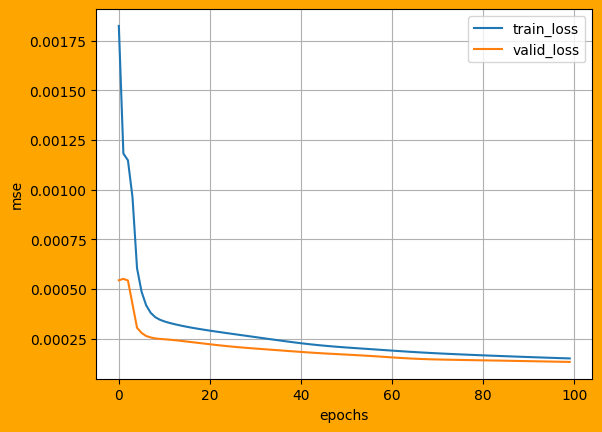

In [27]:
# check convergence
history = json.load(open(os.path.join(output_dir, "history.json")))
f = plt.figure()
f.set_facecolor("orange")
plt.plot(history['train_loss_list'], label='train_loss')
plt.plot(history['valid_loss_list'], label='valid_loss')
plt.xlabel("epochs")
plt.ylabel("mse")
plt.legend()
plt.grid()
plt.show()

### 4. Prediction
+ 4.1 testset
+ 4.2 (optional) metrics
+ 4.3 (optional) data improvement

In [28]:
train_dataset

,series_id,open,high,low,close,volume,y_open,y_high,y_low,y_close,y_volume
0,353,0.239773,0.207326,0.298400,0.233076,0.396764,0.061055,0.052627,0.094400,0.056659,0.560188
1,353,0.233099,0.202431,0.281200,0.223066,0.433987,0.061055,0.052627,0.094400,0.056659,0.560188
2,353,0.223073,0.194944,0.228944,0.195085,0.481120,0.061055,0.052627,0.094400,0.056659,0.560188
3,353,0.195104,0.190924,0.251504,0.213999,0.494951,0.061055,0.052627,0.094400,0.056659,0.560188
4,353,0.213978,0.186089,0.258224,0.202224,0.426791,0.061055,0.052627,0.094400,0.056659,0.560188
...,...,...,...,...,...,...,...,...,...,...,...
78331,663,0.055761,0.046615,0.093552,0.056454,0.345404,0.048772,0.039452,0.084672,0.047291,0.349512
78332,663,0.056459,0.047611,0.092816,0.057931,0.396693,0.048772,0.039452,0.084672,0.047291,0.349512
78333,663,0.057922,0.046699,0.093776,0.054758,0.339655,0.048772,0.039452,0.084672,0.047291,0.349512
78334,663,0.054763,0.045643,0.090880,0.056221,0.410420,0.048772,0.039452,0.084672,0.047291,0.349512


In [31]:
# load checkpoints and inference
ckpt_path = os.path.join(output_dir, "best.pt")
train_dataset_result = train_dataset.copy()
trainloader = trainloader
valid_dataset_result = valid_dataset.copy()
validloader = validloader

model = ToyTimeSeriesRegressionLSTM(
        window_size,
        num_input_features,
        num_output_features,
        hidden_size = 32
    ).to(device)
# model = ToyTransformerEncoder(
#         window_size,
#         num_input_features,
#         num_output_features,
#     ).to(device)
model.load_state_dict(torch.load(ckpt_path))
model.eval()
loss_func = torch.nn.MSELoss(reduction="none")

normalizer = Normalizer(pd.read_csv(f"{output_dir}/dataset_describe.csv", index_col=0))
cols = ["open", "high", "low", "close", "volume"]

for dataset_result, loader, name in [
        (train_dataset_result, trainloader, "train"),
        (valid_dataset_result, validloader, "valid")
    ]:
    prediction_list = []
    loss_list = []
    for x, y in loader:
        with torch.no_grad():
            pred = model(x)
            loss = loss_func(pred, y)
            prediction_list.append(pred.cpu().numpy())  # (B, 4)
            loss_list.append(loss.cpu().numpy())  # (B, 4)
    preds = np.concatenate(prediction_list)  # (N, num_output_features)

    # denormalize
    df_preds = pd.DataFrame(preds, columns=cols)
    df_preds_denorm = normalizer.run(df_preds, denorm_map_dict)
    df_result_x = normalizer.run(dataset_result[cols], denorm_map_dict)
    df_result_y = normalizer.run(
        dataset_result[[f"y_{col}" for col in cols]].rename(columns={f"y_{col}": col for col in cols}),
        denorm_map_dict
    ).rename(columns={col: f"y_{col}" for col in cols})
    df_result = pd.concat([df_result_x, df_result_y], axis=1)
    #print(df_result)
    #print(df_preds_denorm)
    #raise

    preds_repeat = np.repeat(df_preds_denorm.to_numpy(), window_size, axis=0)  # (window_size * N, num_output_features)
    loss = np.concatenate(loss_list)
    loss_repeat = np.repeat(loss, window_size, axis=0)
    df_result[[f"pred_{i}" for i in range(num_output_features)]] = preds_repeat
    df_result[[f"loss_{i}" for i in range(num_output_features)]] = loss_repeat
    df_result.to_csv(os.path.join(output_dir, f"{name}_df_result.csv"), index=False)
    #print(df_result)
    #raise

In [32]:
# plot

df = pd.read_csv("/app/prototype/exp1/output/valid_df_result.csv")
df

,open,high,low,close,volume,y_open,y_high,y_low,y_close,y_volume,pred_0,pred_1,pred_2,pred_3,pred_4,loss_0,loss_1,loss_2,loss_3,loss_4
0,0.013728,0.013861,0.013265,0.013377,4.395252e+09,0.024805,0.025865,0.024030,0.024874,2.419704e+10,0.023670,0.025132,0.023183,0.024275,1.663722e+10,0.000241,0.000077,0.000184,0.000067,0.003477
1,0.013378,0.013463,0.012995,0.013173,6.064223e+09,0.024805,0.025865,0.024030,0.024874,2.419704e+10,0.023670,0.025132,0.023183,0.024275,1.663722e+10,0.000241,0.000077,0.000184,0.000067,0.003477
2,0.013173,0.013566,0.013026,0.013307,6.292246e+09,0.024805,0.025865,0.024030,0.024874,2.419704e+10,0.023670,0.025132,0.023183,0.024275,1.663722e+10,0.000241,0.000077,0.000184,0.000067,0.003477
3,0.013307,0.013700,0.012947,0.013693,7.883602e+09,0.024805,0.025865,0.024030,0.024874,2.419704e+10,0.023670,0.025132,0.023183,0.024275,1.663722e+10,0.000241,0.000077,0.000184,0.000067,0.003477
4,0.013693,0.014588,0.013693,0.014092,1.005762e+10,0.024805,0.025865,0.024030,0.024874,2.419704e+10,0.023670,0.025132,0.023183,0.024275,1.663722e+10,0.000241,0.000077,0.000184,0.000067,0.003477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19579,0.014282,0.014302,0.013538,0.013680,1.078566e+10,0.013397,0.013557,0.013393,0.013473,7.857922e+08,0.012884,0.013010,0.012994,0.012928,9.495509e+09,0.000049,0.000043,0.000041,0.000056,0.153874
19580,0.013680,0.013806,0.012911,0.013059,1.334360e+10,0.013397,0.013557,0.013393,0.013473,7.857922e+08,0.012884,0.013010,0.012994,0.012928,9.495509e+09,0.000049,0.000043,0.000041,0.000056,0.153874
19581,0.013058,0.013249,0.012856,0.013153,8.327111e+09,0.013397,0.013557,0.013393,0.013473,7.857922e+08,0.012884,0.013010,0.012994,0.012928,9.495509e+09,0.000049,0.000043,0.000041,0.000056,0.153874
19582,0.013154,0.013602,0.012819,0.013493,1.069006e+10,0.013397,0.013557,0.013393,0.013473,7.857922e+08,0.012884,0.013010,0.012994,0.012928,9.495509e+09,0.000049,0.000043,0.000041,0.000056,0.153874


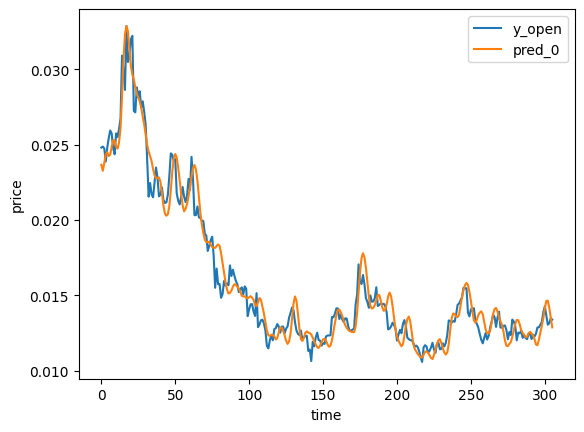

regression of percentage error= 0.05034695876675038
binary classification of percentage acc = 0.5261437908496732


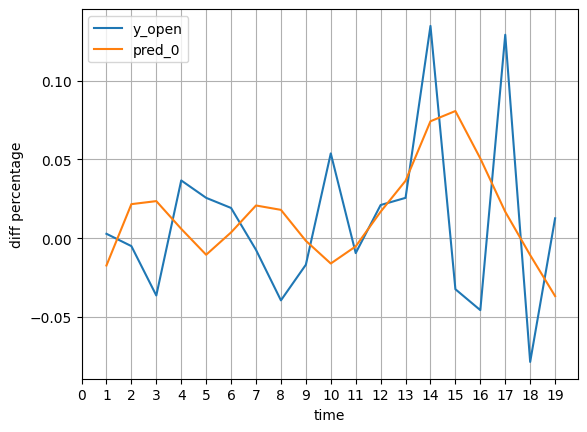

In [61]:
plt.plot(df['y_open'][::64].to_list(), label="y_open")
plt.plot(df['pred_0'][::64].to_list(), label="pred_0")
plt.legend()
plt.xlabel("time")
plt.ylabel("price")
plt.show()

print("regression of percentage error=", (np.abs(df["y_open"] - df["pred_0"]) / df["y_open"]).mean())

y_open_diff = df['y_open'][::64].diff() / df['y_open'][::64][:-1]
pred_0_diff = df['pred_0'][::64].diff() / df['pred_0'][::64][:-1]
print("binary classification of percentage acc =", (y_open_diff * pred_0_diff > 0).sum() / len(y_open_diff))

plt.plot(y_open_diff[:20].to_list(), label="y_open")
plt.plot(pred_0_diff[:20].to_list(), label="pred_0")
plt.legend()
plt.grid(1)
plt.xticks(range(20))
plt.xlabel("time")
plt.ylabel("diff percentage")
plt.show()